# Hồi quy Ridge (gradient descent)

Trong notebook này, chúng ta sẽ triển khai hồi quy Ridge qua gradient descent. Chúng ta sẽ:
* Trích xuất các giá trị DataFrame thành mảng Numpy.
* Viết hàm Numpy để tính đạo hàm của các trọng số hồi quy với một đặc trung duy nhất.
* Viết hàm gradient descent để tính các trọng số hồi quy biết vectơ trọng số ban đầu, kích thước bước, dung sai và L2 penalty.

## Như thường lệ

In [1]:
import sklearn
import pandas
import warnings

warnings.filterwarnings('ignore')

## Load dữ liệu doanh số bán nhà
Tập dữ liệu doanh số bán nhà ở quận King, Seatle, WA. Nghe quen chứ?

In [2]:
full_data = pandas.read_csv("kc_house_data.csv", index_col=0)

Nếu muốn thực hiện bất kỳ "feature engineering" nào như tạo các đặc trưng mới hoặc điều chỉnh đặc trưng sẵn có, chúng ta có thể sửa DataFrame của pandas như trong lab trước (Lab 2). Tuy nhiên, với notebook này, chúng ta sẽ làm việc với các đặc trưng có sẵn.

## Import các hàm hữu ích từ notebook trước

Như trong Lab trước, chúng ta chuyển đổi DataFrame thành ma trận Numpy 2D. Copy và paste `get_numpy_data()` từ notebook Exercise 1.

In [3]:
import numpy as np # điều này cho phép gọi numpy as np

In [4]:
def get_numpy_data(data, features_title, output_title):
    if('constant' not in data):
        data['constant'] = 1 # đây là cách thêm cột constant. Chỉ thực hiện khi cần 
    # thêm cột 'constant' vào trước list các đặc trưng để chúng ta có thể trích xuất cùng với những thứ khác:
    features_title = ['constant'] + features_title # đây là cách kết hợp 2 list
    # chia dữ liệu thành sub-DataFrame chứa các đặc trưng đã chỉ định (gồm constant)
    # gọi nó là features_columns.
    features_columns = data[features_title]
    # dòng tiếp theo sẽ trích xuất ma trận numpy từ biến features_columns:
    feature_matrix = features_columns.values
    # truy xuất dữ liệu được liên kết với đầu ra trong pandas Series
    # gọi nó là output_column
    output_column = data[output_title]
    # tiếp theo sẽ chuyển đổi Series đã nhắc thành một mảng numpy
    output_array = output_column.values
    return(feature_matrix, output_array)

Cũng copy và paste cả hàm `predict_output()` để tính các dự đoán cho toàn bộ ma trận đặc trưng với ma trận và trọng số đã cho:

In [5]:
def predict_output(feature_matrix, weights):
    # giả sử ma trận feature_matrix chứa các đặc trưng ở dạng các cột và trọng số là mảng numpy tương ứng
    # tạo vectơ dự đoán sử dụng np.dot()
    predictions = np.dot(feature_matrix, weights)
    return predictions

## Tính đạo hàm

Bây giờ chúng ta sẽ chuyển sang tính đạo hàm của hàm chi phí hồi quy. Hàm chi phí là tổng các điểm dữ liệu của bình phương của hiệu giữa kết quả quan sát và kết quả dự đoán cộng với L2 penalty.
<!-- ``` Cost(w) = SUM[ (prediction - output)^2 ] + l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2). ``` This is commented out. -->
$ cost_w = \sum (prediction - output)^2 + l2\_penalty * \sum_i w_i^2 $ (trong đó $w_0$ là độ chệch)

Vì đạo hàm của một tổng là tổng các đạo hàm nên chúng ta có thể tính đạo hàm của phần đầu tiên (RSS) như đã thực hiện trong notebook về trường hợp được điều chuẩn và cộng đạo hàm của phần điều chuẩn. Chúng ta có thể viết đạo hàm với $w_i$(`w[i]`)  như sau:
<!-- ``` 2*SUM[ error*[feature_i] ]. ``` -->
$ 2 * \sum error * feature_i $

Đạo hàm của phần điều chuẩn với $w_i$ là:
<!-- ``` 2*l2_penalty*w[i]. ``` -->
$ 2 * l2\_penalty * w_i $

Cộng cả 2 lại, chúng ta được:
<!-- ``` 2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i]. ``` -->
$ 2 * \sum error * feature_i + 2 * l2\_penalty * w_i $

Đây là đạo hàm cho trọng số của đặc trưng i, là tổng (trên các điểm dữ liệu) của 2 nhân với tích của sai số và chính đặc trưng cộng với `2*l2_penalty*w[i]`. 

**Chúng ta sẽ không điều chuẩn hóa hằng số.**  Do đó, trong trường hợp hằng số thì đạo hàm sẽ bằng 2 lần tổng các sai số (không có phần tử `2*l2_penalty*w[0]`).

2 lần tổng của tích hai vectơ chỉ là hai nhân tích của hai vectơ. Do đó, đạo hàm cho trọng số của $feature_i$ bằng hai lần tích vô hướng giữa các giá trị $feature_i$ và sai số hiện tại cộng với $2*l2\_penalty*w_i$. 


Hãy hoàn thành hàm đạo hàm sau đây để tính đạo hàm của trọng số cho giá trị của đặc trưng (trên tất cả các điểm dữ liệu) và sai số (trên tất cả các điểm dữ liệu). Để quyết định khi nào thì xử lý hằng số (chúng ta không điều chuẩn nó), chúng ta thêm tham số bổ sung để gọi `feature_is_constant` đặt thành `True` khi tính đạo hàm của hằng số và `False` nếu không phải.

In [6]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # Nếu feature_is_constant là True thì đạo hàm bằng 2 nhân tích vô hướng của sai số và đặc trưng
    if feature_is_constant is True:
        derivative = 2 * np.dot(errors, feature)
    # Nếu không, đạo hàm bằng 2 nhân tích vô hướng cộng với 2*l2_penalty*weight
    else:
        derivative = 2 * np.dot(errors, feature) + 2*(l2_penalty*weight)
    return derivative

Để kiểm tra đạo hàm, chạy cell sau:

In [7]:
(example_features, example_output) = get_numpy_data(full_data, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # các sai số dự đoán

# 2 dòng tiếp theo in các giá trị tương tự
print(feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print(np.sum(errors*example_features[:,1])*2+20.)

print("-------")
# 2 dòng tiếp theo in các giá trị tương tự
print(feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print(np.sum(errors)*2.0)

-56554166815950.0
-56554166815950.0
-------
-22446749330.0
-22446749330.0


# Gradient Descent

Bây giờ chúng ta sẽ viết một hàm thực hiện gradient descent. Tiền đề cơ bản khá đơn giản. Với một điểm bắt đầu, chúng ta cập nhật các trọng số hiện tại bằng cách di chuyển theo hướng gradient âm. Gradient có hướng *tăng* nên gradient âm có hướng *giảm* và chúng ta đang cố gắng *giảm thiểu* hàm chi phí.  


Lượng mà chúng ta di chuyển theo *hướng* gradient âm được gọi là 'kích thước bước'. Chúng ta dừng lại khi chúng ta 'đủ gần' với mức tối ưu. Không giống lần trước, lần này chúng ta sẽ đặt **số lần lặp tối đa** và thực hiện các bước gradient cho tới khi đạt tới số lượng tối đa này. Nếu không cấp số lượng tối đa thì max sẽ được đặt mặc định là 100 (Sử dụng các giá trị tham số mặc định trong Python).

Hãy hoàn thành hàm gradient descent sau bằng cách sử dụng hàm đạo hàm ở trên. Với mỗi bước trong gradient descent, chúng ta cập nhật trọng số cho từng đặc trưng trước khi tính tiêu chí dừng.

In [20]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):

    weights = np.array(initial_weights) 
    
    while max_iterations > 0:
    
        predictions = predict_output(feature_matrix, weights)
        
        errors = predictions - output
        
        for i in range(len(weights)): # loop over each weight

            if i == 0:
                feature_is_constant = True
            else:
                feature_is_constant = False
                
            derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, feature_is_constant)

            weights[i] = weights[i] - (step_size * derivative)
            
        max_iterations -= 1        
        
    return weights

## Hiển thị tác động của L2 penalty

L2 penalty được đặt tên như vậy vì nó khiến các trọng số có chuẩn L2 nhỏ hơn so với các trường hợp khác. Hãy xem các trọng số lớn bị phạt như thế nào. Chúng ta sẽ xem xét một mô hình đơn giản có 1 đặc trưng:

In [15]:
simple_features = ['sqft_living']
my_output = 'price'

Hãy chia thành tập huấn luyện và tập kiểm tra. Đảm bảo dùng `seed=0`:

In [16]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(full_data, train_size=0.8, test_size=0.2, random_state=0)

Trong phần này, chúng ta sẽ chỉ dùng `'sqft_living'` để dự đoán `'price'`. Sử dụng hàm `get_numpy_data` để lấy phiên bản Numpy cảu dữ liệu chỉ với đặc trưng này cho cả `train_data` và `test_data`. 

In [17]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Đặt các tham số cho tối ưu hóa:

In [18]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

Trước tiên, chúng ta sẽ xét không có điều chuẩn. Đặt `l2_penalty` thành `0.0` và chạy thuật toán hồi quy Ridge để tìm hiểu các trọng số của mô hình. Gọi trọng số :

`simple_weights_0_penalty`

chúng ta sẽ sử dụng chúng sau.

In [21]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             0.0, max_iterations)
print(simple_weights_0_penalty)

[-1.68107747e-01  2.64595376e+02]


Tiếp theo, hãy xét với điều chuẩn cao. Đặt `l2_penalty` bằng `1e11` và chạy thuật toán hồi quy Ridge để tìm hiểu các trọng số của mô hình. Gọi trọng số:

`simple_weights_high_penalty`

chúng ta sẽ sử dụng chúng sau.

In [22]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                                initial_weights, step_size, 
                                                                1e11, max_iterations)
print(simple_weights_high_penalty)

[  9.79155301 125.07002033]


Code này sẽ vẽ biểu đồ 2 mô hình đã tìm hiểu. (Đường màu xanh dương biểu thị mô hình không điều chuẩn, đường màu đỏ biểu thị mô hình với điều chuẩn cao). 

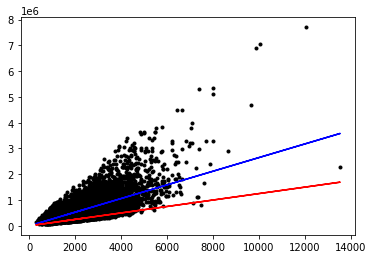

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix[:, 1:], output,'k.',
         simple_feature_matrix[:, 1:], predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
         simple_feature_matrix[:, 1:], predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

**Tại sao `[:, 1:]`? ¯\\\_(ツ)\_/¯ Chúng ta cần tìm hiểu**

Tính RSS trên dữ liệu KIỂM TRA cho ba tập hợp trọng số sau:
1. Các trọng số ban đầu (các số 0)
2. Các trọng số đã tìm hiểu khi không điều chuẩn
3. Các trọng số đã tìm hiểu có điều chuẩn cao

Những trọng số nào thể hiện tốt nhất?

In [24]:
# Một lần nữa thực hiện trong ba tập hợp
RSS_0 = np.sum((test_output - predict_output(simple_test_feature_matrix, initial_weights))**2)
RSS_1 = np.sum((test_output - predict_output(simple_test_feature_matrix, simple_weights_0_penalty))**2)
RSS_2 = np.sum((test_output - predict_output(simple_test_feature_matrix, simple_weights_high_penalty))**2)

In [25]:
# Hoặc thực hiện trong một tập hợp
print(f'RSS_0: {RSS_0} \nRSS_1: {RSS_1} \nRSS_2: {RSS_2}')

RSS_0: 1724972157778353.0 
RSS_1: 267785724039172.34 
RSS_2: 650754968300805.6


***QUIZ***
1. Giá trị của hệ số cho `sqft_living` đã tìm hiểu khi không điều chuẩn (làm tròn tới chữ số thập phân thứ nhất) là bao nhiêu? Giá trị của hệ số cho `sqft_living` đã tìm hiểu với điều chuẩn cao (làm tròn tới chữ số thập phân thứ nhất) là bao nhiêu?
2. So sánh hai đường khớp với điều chuẩn cao và không điều chuẩn, đường nào dốc hơn?
3. RSS trên dữ liệu KIỂM TRA cho từng tập hợp trọng số trên (ban đầu, không điều chuẩn, điều chuẩn cao) là bao nhiêu?


## Chạy hồi quy đa biến với L2 penalty

Xét mô hình với 2 đặc trưng: `['sqft_living', 'sqft_living15']`.

Trước tiên, tạo các phiên bản Numpy của dữ liệu huấn luyện và kiểm tra với 2 đặc trưng đó.

In [26]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 là diện tích trung bình cho 15 hàng xóm gần nhất. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

Chúng ta cần khởi tạo lại các trọng số do có thêm một tham số. Hãy thiết lập kích thước bước và số lần lặp tối đa.

In [27]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

Trước tiên, xét không điều chuẩn. Đặt `l2_penalty` thành `0.0` và chạy thuật toán hồi quy Ridge để tìm hiểu trọng số của mô hình. Gọi trọng số:

`multiple_weights_0_penalty`

In [28]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 
                                                               0.0, max_iterations)
print(multiple_weights_0_penalty)

[ -0.36105686 245.10302972  21.88723514]


Tiếp theo, xét điều chuẩn cao. Đặt `l2_penalty` thành `1e11` và chạy thuật toán hồi quy Ridge để tìm hiểu trọng số của mô hình. Gọi trọng số:

`multiple_weights_high_penalty`

In [29]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 
                                                               1e11, max_iterations)
print(multiple_weights_high_penalty)

[ 6.76344892 91.93393155 78.75003429]


Tính RSS trên dữ liệu KIỂM TRA cho ba tập hợp trọng số sau:
1. Trọng số ban đầu (các số 0)
2. Trọng số đã tìm hiểu không điều chuẩn
3. Trọng số đã tìm hiểu với điều chuẩn cao

Các trọng số nào thực hiện tốt nhất?

In [30]:
# Thấy rồi chứ?
# Một lần nữa thực hiện trong ba tập hợp
RSS_0 = np.sum((test_output - predict_output(test_feature_matrix, initial_weights))**2)
RSS_1 = np.sum((test_output - predict_output(test_feature_matrix, multiple_weights_0_penalty))**2)
RSS_2 = np.sum((test_output - predict_output(test_feature_matrix, multiple_weights_high_penalty))**2)

In [31]:
# Cũng hãy chú ý 'constant'
# Hoặc thực hiện trong một tập hợp
print(f'RSS_0: {RSS_0} \nRSS_1: {RSS_1} \nRSS_2: {RSS_2}')

RSS_0: 1724972157778353.0 
RSS_1: 266037590365260.84 
RSS_2: 462809239744846.25


Dự đoán giá nhà cho ngôi nhà thứ 5 trong tập kiểm tra sử dụng mô hình không điều chuẩn và mô hình có điều chuẩn cao. (Nhớ rằng Python bắt đầu lập chỉ mục từ 0). Dự đoán cách giá thực tế bao nhiêu? Các trọng số nào thực hiện tốt nhất với ngôi nhà thứ nhất?

In [32]:
test_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,constant
id,,,,,,,,,,,,,,,,,,,,,
1453602313,20141029T000000,297000.0,2,1.50,1430,1650,3.0,0,0,3,...,1430,0,1999,0,98125,47.7222,-122.290,1430,1650,1
2225059214,20140808T000000,1578000.0,4,3.25,4670,51836,2.0,0,0,4,...,4670,0,1988,0,98005,47.6350,-122.164,4230,41075,1
2768000270,20140625T000000,562100.0,2,0.75,1440,3700,1.0,0,0,3,...,1200,240,1914,0,98107,47.6707,-122.364,1440,4300,1
6819100040,20140624T000000,631500.0,2,1.00,1130,2640,1.0,0,0,4,...,1130,0,1927,0,98109,47.6438,-122.357,1680,3200,1
4027700666,20150426T000000,780000.0,4,2.50,3180,9603,2.0,0,2,3,...,3180,0,2002,0,98155,47.7717,-122.277,2440,15261,1


In [33]:
# Đây cũng là quiz
zero_price_house_5 = predict_output(test_feature_matrix[4], multiple_weights_0_penalty)
zero_price_house_5

832832.127187328

In [34]:
# Nên hãy vô cùng cẩn thận
high_price_house_5 = predict_output(test_feature_matrix[4], multiple_weights_high_penalty)
high_price_house_5

484506.74944128346

***QUIZ***
1. Giá trị của hệ số cho `sqft_living` đã tìm hiểu khi không điều chuẩn (làm tròn tới chữ số thập phân thứ nhất) là bao nhiêu? Giá trị của hệ số cho `sqft_living` đã tìm hiểu với điều chuẩn cao (làm tròn tới chữ số thập phân thứ nhất) là bao nhiêu?
2. RSS trên dữ liệu KIỂM TRA cho từng tập hợp trọng số trên (ban đầu, không điều chuẩn, điều chuẩ cao) là bao nhiêu?
3. Chúng ta đưa ra dự đoán cho ngôi nhà thứ năm trong tập kiểm tra sử dụng hai tập hợp trọng số (không điều chuẩn với điều chuẩn cao). Trọng số nào cho dự đoán sát hơn <u>với ngôi nhà đó</u>?

====================End============================